In [95]:
import torch
import torch.nn as nn
import torch.optim as optim
import sklearn.datasets
import torch.utils.data
from torch import nn
from torch.nn import functional as F
import numpy as np

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

# Set random seed for PyTorch
torch.manual_seed(42)

# Set random seed for NumPy
np.random.seed(42)

In [96]:
DEBUG_MODE = False

def debug(input):
    if DEBUG_MODE == True:
        print(input)
    else:
        pass

In [97]:
# Model
class DynamicModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, softmax = False):
        super(DynamicModel, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.softmax = softmax
        self.softmax_function = nn.Softmax(dim=1)

        # Define layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.batchnorm = nn.BatchNorm1d(hidden_dim)

    def forward(self, x):
        x = self.relu(self.batchnorm(self.fc1(x)))
        x = self.relu(self.batchnorm(self.fc2(x)))
        x = self.relu(self.batchnorm(self.fc3(x)))
        if self.output_dim == 2:
            x = self.fc4(x)
            return x if self.softmax == False else self.softmax_function(x)
        if self.output_dim > 2: 
            x = self.fc4(x)
            h = x[:, :2]
            additional_params = x[:, 2:]
            return x


In [98]:
from torchmetrics.classification import BinaryAccuracy

def train(model, criterion, optimizer, num_epochs = 50):
    
    losses = []
    accuracy_scores = []
    
    metric = BinaryAccuracy(multidim_average='samplewise')

    for epoch in range(num_epochs):
        running_loss = 0.0
        accuracies = []
        for inputs, labels in train_loader: # train_loader is defined outside the function
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            accuracy = metric(outputs[:, :labels.size(1)], labels)
            accuracies.append(accuracy)
            running_loss += loss.item()
        #print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")
        losses.append(running_loss)
        accuracy_scores.append(np.mean(accuracies))
    print('Training Completed')
    print(f' Average Accuracy: {np.mean(accuracy_scores)}')
    
    return losses, accuracy_scores

In [99]:
class UANLLoss(nn.Module):
    def __init__(self, smoothing = 0.1):
        super(UANLLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        #self.clc = classes
        
    def forward(self,x,y):
        m = y.size(0)  # batch size
        N = y.size(1)  # number of classes
        debug(f'N: {N}')
        logstd  = (x[:,N:]) #** 2 #torch.sigmoid(x[:,self.clc:])#(x[:,NUM_CLASSES:]) ** 2#
        prob = nn.functional.softmax(x[:,:N],1)

        with torch.no_grad():
            yoh = torch.zeros_like(prob)
            yoh.fill_(self.smoothing / (N - 1))
            debug(f'yoh shape: {yoh.shape}')
            debug(f'y.data shape: {y.data.shape}')
            #debug(f'y.data shape unsqueeze: {y.data.unsqueeze(1).unsqueeze(1)}')
            yoh.scatter_(1, y.data.to(torch.int64), self.confidence)

        #loss0 = (yoh - prob) ** 2
        loss0 = (y - prob) ** 2
        loss = (torch.exp(-logstd) * loss0.sum(dim=1) + N * logstd)

        return loss.mean() #loss.mean() #(1.0 - cosyh).mean() #loss

In [100]:
import torch
import torch.nn as nn

class UncertaintyAwareLoss(nn.Module):
    def __init__(self, smoothing=0.0):
        super(UncertaintyAwareLoss, self).__init__()
        self.smoothing = smoothing

    def forward(self, model_output, y_true):
        """
        Compute the UANLL loss: .

        Args:
            y_pred (torch.Tensor): Predictions from the model (h_k^i).
                                   Shape: (batch_size, N).
            y_true (torch.Tensor): True labels (y_k^i).
                                   Shape: (batch_size, N).
            s (torch.Tensor): Uncertainty measure (s^i).
                              Shape: (batch_size,).

        Returns:
            torch.Tensor: Loss value.
        """
        
                
        m = y_true.size(0)  # batch size
        N = y_true.size(1)  # number of classes
        
        y_pred = model_output[:, :N]
        s = model_output[:, N]
    
        y_pred = torch.softmax(y_pred, dim=1)
    


        squared_diff = (y_pred - y_true) ** 2  # squared difference
        #variance_term = torch.exp(-s) * torch.sum(squared_diff, dim=1)  # variance term
        variance_term = torch.div(1, s ** 2) * torch.sum(squared_diff, dim=1)
        loss = torch.mean(variance_term + N * torch.log(s ** 2)) / 2  # compute loss
        
        debug('-----Loss Output-----')
        debug(f'm: {m}\nn: {N}')
        debug(f'Variance: {s}')
        debug(f'Squared Diff: {squared_diff[:3, :3]}')
        debug(f'Variance Term: {variance_term[:3]}')
        debug(f'Loss: {loss}')
        debug('-End of Loss Output---')

        # Apply label smoothing
        if self.smoothing > 0.0:
            smoothed_true = y_true * (1 - self.smoothing) + self.smoothing / N
            loss -= torch.sum(smoothed_true * torch.log(y_pred + 1e-9)) / m

        return loss

# Data Loader

In [101]:
noise = 0.1
batch_size = 64

X_train, y_train = sklearn.datasets.make_moons(n_samples=1000, noise=noise)
X_test, y_test = sklearn.datasets.make_moons(n_samples=200, noise=noise)

train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_train).float(), F.one_hot(torch.from_numpy(y_train)).float())
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_test).float(), F.one_hot(torch.from_numpy(y_test)).float())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=200, shuffle=False)

# CE Loss
Softmax applied to the model's output

Training Completed
 Average Accuracy: 0.9933750033378601


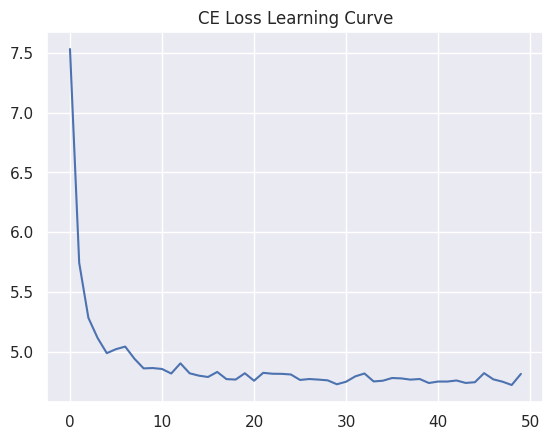

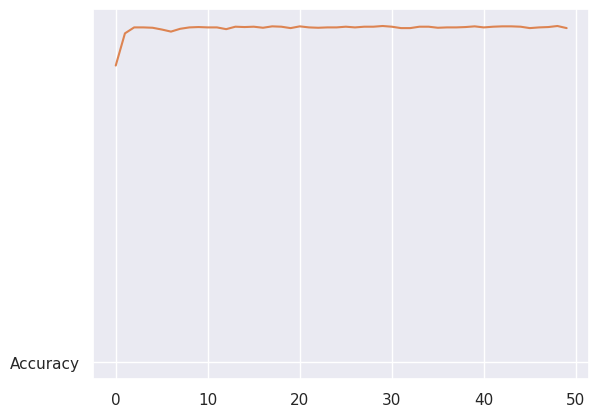

In [102]:
input_dim = 2
hidden_dim = 64
output_dim = 2

model = DynamicModel(input_dim, hidden_dim, output_dim, softmax = True)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
losses, accuracy = train(model, criterion, optimizer)   
    
plt.plot(losses)
plt.title('CE Loss Learning Curve')
plt.show()

plt.plot('Accuracy')
plt.plot(accuracy)
plt.show()

Using softmax in the last layer


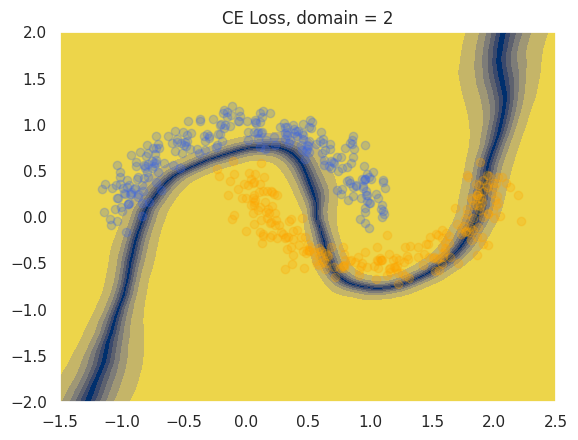

In [103]:

domain = 2 # the range of the grid
x_lin = np.linspace(-domain+0.5, domain+0.5, 200)
y_lin = np.linspace(-domain, domain, 200)

xx, yy = np.meshgrid(x_lin, y_lin)

X_grid = np.column_stack([xx.flatten(), yy.flatten()])

X_vis, y_vis = sklearn.datasets.make_moons(n_samples=500, noise=noise)
mask = y_vis.astype(np.bool_)

with torch.no_grad():
    output = model(torch.from_numpy(X_grid).float())
    confidence = output.max(1)[0].numpy()


z = confidence.reshape(xx.shape)

plt.figure()
plt.contourf(x_lin, y_lin, z, cmap='cividis')

plt.scatter(X_vis[mask,0], X_vis[mask,1], alpha=0.25, color='orange')
plt.scatter(X_vis[~mask,0], X_vis[~mask,1], alpha=0.25, color='royalblue')
print('Using softmax in the last layer')
plt.title('CE Loss, domain = 2')
plt.show()

When we pass less data to the model (domain = 1), the area of the lowest confidence fits the class border more precisely 

Using softmax in the last layer


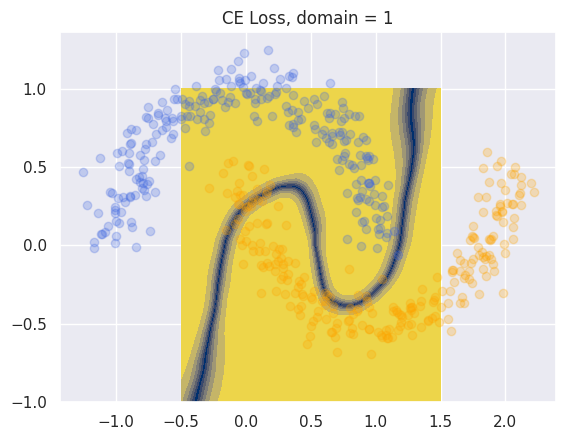

In [104]:

domain = 1
x_lin = np.linspace(-domain+0.5, domain+0.5, 200)
y_lin = np.linspace(-domain, domain, 200)

xx, yy = np.meshgrid(x_lin, y_lin)

X_grid = np.column_stack([xx.flatten(), yy.flatten()])

X_vis, y_vis = sklearn.datasets.make_moons(n_samples=500, noise=noise)
mask = y_vis.astype(np.bool_)

with torch.no_grad():
    output = model(torch.from_numpy(X_grid).float())
    confidence = output.max(1)[0].numpy()


z = confidence.reshape(xx.shape)

plt.figure()
plt.contourf(x_lin, y_lin, z, cmap='cividis')

plt.scatter(X_vis[mask,0], X_vis[mask,1], alpha=0.25, color='orange')
plt.scatter(X_vis[~mask,0], X_vis[~mask,1], alpha=0.25, color='royalblue')
print('Using softmax in the last layer')
plt.title('CE Loss, domain = 1')
plt.show()

# UANLL Loss 

Training Completed
 Average Accuracy: 0.9883436560630798


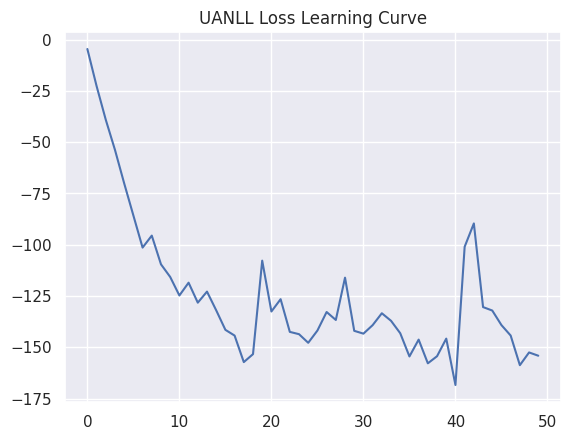

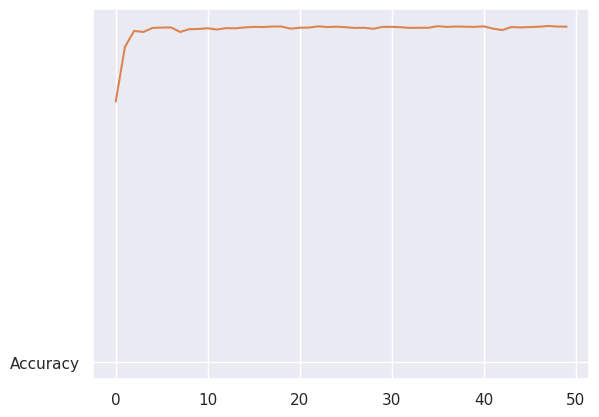

In [105]:
# Setting dimensions of the model
input_dim = 2
hidden_dim = 64
output_dim = 3

model = DynamicModel(input_dim, hidden_dim, output_dim)

# Setting Loss criterion and Optimizer
criterion = UANLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
losses, accuracy = train(model, criterion, optimizer)   
    
plt.plot(losses)
plt.title('UANLL Loss Learning Curve')
plt.show()

plt.plot('Accuracy')
plt.plot(accuracy)
plt.show()

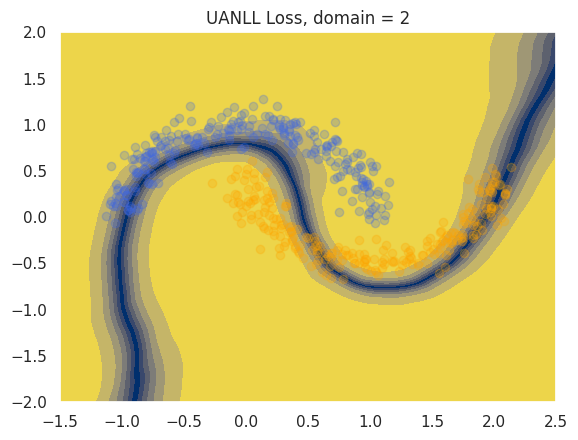

In [106]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

sns.set()

domain = 2
x_lin = np.linspace(-domain+0.5, domain+0.5, 200)
y_lin = np.linspace(-domain, domain, 200)

xx, yy = np.meshgrid(x_lin, y_lin)

X_grid = np.column_stack([xx.flatten(), yy.flatten()])

X_vis, y_vis = sklearn.datasets.make_moons(n_samples=500, noise=noise)
mask = y_vis.astype(np.bool_)

with torch.no_grad():
    output = model(torch.from_numpy(X_grid).float())
    output = torch.hstack([(torch.softmax(output[:, :2], dim=1)), output[:, 2].unsqueeze(1)])
    confidence = output.max(1)[0].numpy()
    

z = confidence.reshape(xx.shape)

plt.figure()
plt.contourf(x_lin, y_lin, z, cmap='cividis')

plt.scatter(X_vis[mask,0], X_vis[mask,1], alpha=0.25, color='orange')
plt.scatter(X_vis[~mask,0], X_vis[~mask,1], alpha=0.25, color='royalblue')
plt.title('UANLL Loss, domain = 2')
plt.show()

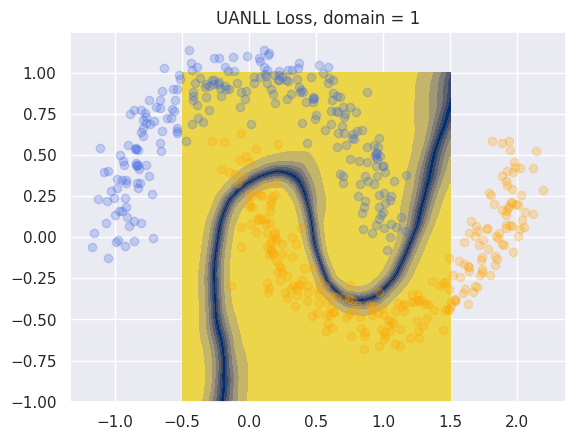

In [107]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

sns.set()

domain = 1
x_lin = np.linspace(-domain+0.5, domain+0.5, 200)
y_lin = np.linspace(-domain, domain, 200)

xx, yy = np.meshgrid(x_lin, y_lin)

X_grid = np.column_stack([xx.flatten(), yy.flatten()])

X_vis, y_vis = sklearn.datasets.make_moons(n_samples=500, noise=noise)
mask = y_vis.astype(np.bool_)

with torch.no_grad():
    output = model(torch.from_numpy(X_grid).float())
    #output = torch.hstack([(torch.softmax(output[:, :2], dim=1)), output[:, 2].unsqueeze(1)])
    output = torch.softmax(output[:, :2], dim=1)
    confidence = output.max(1)[0].numpy()


z = confidence.reshape(xx.shape)

plt.figure()
plt.contourf(x_lin, y_lin, z, cmap='cividis')

plt.scatter(X_vis[mask,0], X_vis[mask,1], alpha=0.25, color='orange')
plt.scatter(X_vis[~mask,0], X_vis[~mask,1], alpha=0.25, color='royalblue')
plt.title('UANLL Loss, domain = 1')
plt.show()